<a href="https://colab.research.google.com/github/LudmilaAmriou/Gender_Age_DetectionCNNs/blob/main/age_gender_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install keras tensorflow --upgrade
# !pip install numpy matplotlib pillow h5py

---
# ***Data importation and preparation***
---




In [ ]:
# Connect to google drive and import Dataset UTKFace (found in Kaggle)
from google.colab import drive
drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/dataset.zip -d /content/
# BASE_DIR = '/content/dataset/UTKFace/'


Mounted at /content/drive


In [ ]:
# Import essential libraries
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
#dataset_folder_name = '/content/drive/My Drive/Images'

TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

# Mapping gender and race with their IDs
dataset_dict = {
    'race_id': {
        0: 'white',
        1: 'black',
        2: 'asian',
        3: 'indian',
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id in our dataset)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id in our dataset)

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and race) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']


    df = df.dropna()

    return df

In [ ]:
df = parse_dataset('/content/dataset/UTKFace/')
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and
# visualize data by plotting graphs.



,age,gender,race,file
0,29.0,male,black,/content/dataset/UTKFace/29_0_1_20170113145429...
1,72.0,female,white,/content/dataset/UTKFace/72_1_0_20170110161254...
2,30.0,female,others,/content/dataset/UTKFace/30_1_4_20170103230152...
3,42.0,male,indian,/content/dataset/UTKFace/42_0_3_20170119204253...
4,23.0,female,asian,/content/dataset/UTKFace/23_1_2_20170104021026...


---
# ***Data analysis & visualization (EDA)***
---



In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23705 non-null  float64
 1   gender  23705 non-null  object 
 2   race    23705 non-null  object 
 3   file    23705 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.0+ KB


In [ ]:
df.describe()

# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


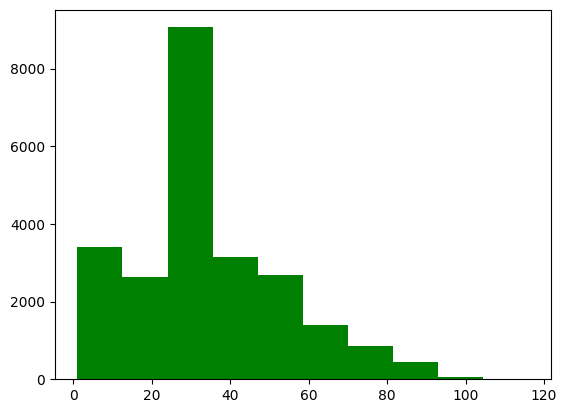

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Majority population lies between 20-30 age group. Clearly, the dataset is not very well balanced. So training will
# not be easy & accurate. We don't want to be biased. Try using class weights ?

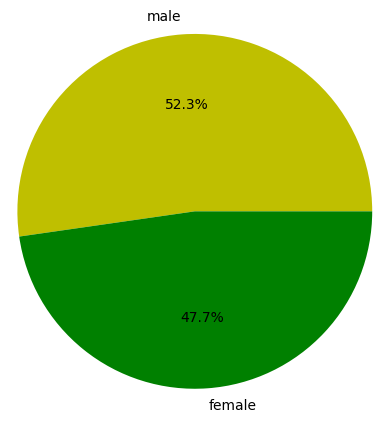

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g']
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data.
# Pretty well balanced ! Lets also visualize this on a bar graph (to get better understanding of numbers)

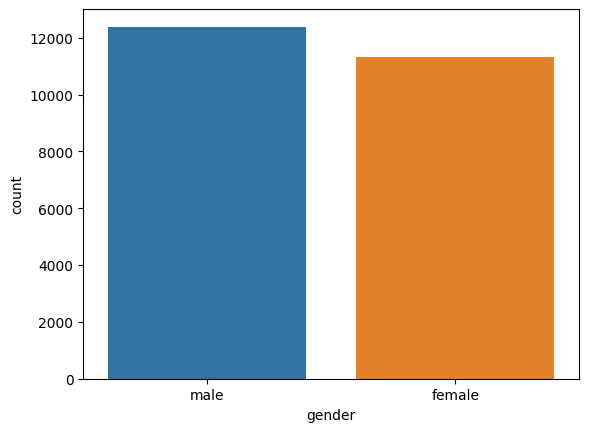

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean()             # Mean age by gender

,age
gender,
female,30.678186
male,35.695666


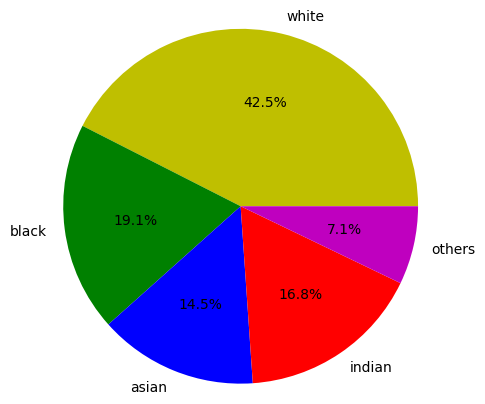

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m']
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.867501
black,33.860362
indian,31.532830
others,23.169031
white,37.980949


In [ ]:
sns.set(style ="whitegrid")
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) in others category are present

df.groupby(['race']).mean()               # Mean age by race

NameError: ignored

In [ ]:
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups -
1. 0-24
2. 25-49
3. 50-74
4. 75-99
5. 100-124 '''

' This basically makes 5 divisions in age-groups - \n1. 0-24\n2. 25-49\n3. 50-74\n4. 75-99\n5. 100-124 '

In [ ]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c)

6903   11815   3988   967   32   0


In [ ]:
df.head()

,age,gender,race,file
0,1.0,male,black,/content/dataset/UTKFace/29_0_1_20170113145429...
1,2.0,female,white,/content/dataset/UTKFace/72_1_0_20170110161254...
2,1.0,female,others,/content/dataset/UTKFace/30_1_4_20170103230152...
3,1.0,male,indian,/content/dataset/UTKFace/42_0_3_20170119204253...
4,0.0,female,asian,/content/dataset/UTKFace/23_1_2_20170104021026...



---
# ***Data Generator: Batch creation***
##### This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).
---

In [ ]:
from keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df)) # Create random permutations (numpy)

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)  # Take 80 % of our data for training
train_idx = p[:train_up_to] # Keep indexes of training set
val_idx = p[train_up_to:]  # Keep indexes of test set

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx

def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.

    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0

    return im

def generate_images(image_idx, is_training, batch_size=16):  # Used to generate a batch with images when training/validating our model.

    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx: # For each batch preform transformations
            person = df.iloc[idx]

            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']

            im = preprocess_image(file)

            # Convert output labels (age,gender and race into hot encoded vectors) (categories) (2 columns for gender)
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)

            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []

        if not is_training:
            break

---
# ***Model Architecture***
---
Convolutional neural networks work on 2 assumptions:

>**1. Low level features are local:** the features that the CNN extracts from an image are based on small, local regions of the image. This is achieved through the use of convolutional layers, which apply a set of learnable filters, or kernels, to small regions of the input image at a time, and then combine the results to produce a set of feature maps that highlight different aspects of the image

>**2. What's useful in one place will also be useful in other places:** he same set of filters can be used to extract features from different regions of the image. This is achieved through the use of weight sharing, which means that the same set of filters is applied to all regions of the input image, regardless of where they are located.

Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand. In general, smaller filters are considered better than larger filter sizes. Also, usually:

* Number of filters tend to increase with depth of model (more representational capacity is required in the model)

* Size of filters is almost always odd. Like 3x3, 5x5

* Filter size tends to decrease with depth of the model (initial layers have larger receptive fields).

In [ ]:
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

#  Defines a set of convolutional layers with increasing depth, as well as activation, pooling, and normalization layers
def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x
'''
The build_gender_branch and build_age_branch functions define two separate fully connected layers on top of the common convolutional layers;
one for predicting gender and the other for predicting age.
The layers have different numbers of neurons, and dropout and batch normalization layers are added to improve generalization and prevent overfitting.
'''
def build_gender_branch(inputs):

    x = make_default_hidden_layers(inputs)
    # Flatten into one dim vector (add fully connected layers)
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x) # Categorical many classes

    return x

def build_age_branch(inputs):

    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)  # Categorical

    return x

# Assemble the model results by combining the two output branches (gender and age) and defining the input shape of the model.
def assemble_model(width, height):

    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="face_net")

    return model

model = assemble_model(198, 198)

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 198, 198, 32  155        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 activation (Activation)        (None, 198, 198, 32  0           ['separable_conv2d[0][0]']       
                                )                                                          

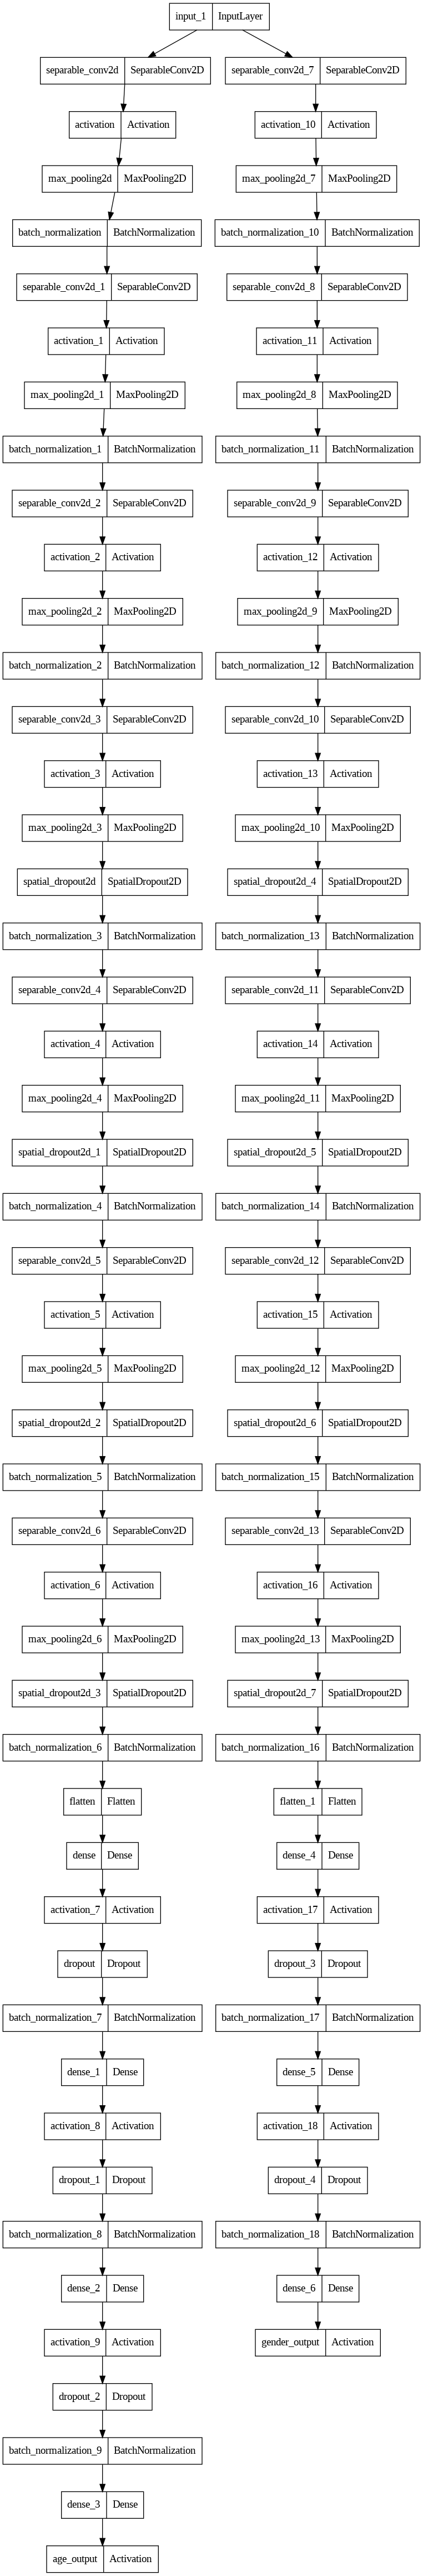

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

---
# ***Model training***
---

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

'''
When training a neural network, the learning rate is often the most important
hyperparameter to tune. When training deep neural networks, it is often useful
to reduce learning rate as the training progresses.

LRS in Keras reduces the learning rate by a certain factor after certain no of epochs.
Here the initial lrate is 0.008 and then it'll be reduced by a factor of 0.5 after every 5 epochs
'''
def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)
# Accuracy for age and gender (metric) + loss function
model.compile(optimizer=opt,
              loss={
                  'age_output': 'categorical_crossentropy',
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy',
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

'''
Keras does not touch class imbalance issues on its own.
If you aren't going to handle imbalance from the data directly, you should introduce an additional parameter in your loss function that understands the class distribution.
In Keras, the param is called class_weight
Class weights, ensure that the unevenness in data distribution is sorted out.
(classes with less numbers are given more weight, so that model doesn't get biased towards the more prevalent classes.)
'''

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0,1,2,3,4]), y=np.array(df['age']))

class_weight1 = {'age_output': class_weights}

In [ ]:
train_gen = generate_images(train_idx, is_training=True, batch_size=32)

# Since, train_idx is too large to fit inside RAM at once, we generate batches of size 32/64 from it (called train_gen))

valid_gen = generate_images(val_idx, is_training=False, batch_size=32)


history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)

Epoch 1/22
592/592 [==============================] - 109s 170ms/step - loss: 2.1333 - age_output_loss: 1.1417 - gender_output_loss: 0.5645 - age_output_accuracy: 0.5207 - gender_output_accuracy: 0.7022 - val_loss: 1.7060 - val_age_output_loss: 0.9991 - val_gender_output_loss: 0.5490 - val_age_output_accuracy: 0.5925 - val_gender_output_accuracy: 0.7863 - lr: 0.0080
Epoch 2/22
592/592 [==============================] - ETA: 0s - loss: 1.4671 - age_output_loss: 0.9043 - gender_output_loss: 0.3768 - age_output_accuracy: 0.6243 - gender_output_accuracy: 0.8305

592/592 [==============================] - 80s 136ms/step - loss: 1.4671 - age_output_loss: 0.9043 - gender_output_loss: 0.3768 - age_output_accuracy: 0.6243 - gender_output_accuracy: 0.8305 - lr: 0.0080
Epoch 3/22
592/592 [==============================] - 81s 138ms/step - loss: 1.3085 - age_output_loss: 0.7925 - gender_output_loss: 0.3295 - age_output_accuracy: 0.6681 - gender_output_accuracy: 0.8563 - lr: 0.0080
Epoch 4/22
592/592 [==============================] - 81s 137ms/step - loss: 1.2428 - age_output_loss: 0.7547 - gender_output_loss: 0.3045 - age_output_accuracy: 0.6808 - gender_output_accuracy: 0.8640 - lr: 0.0080
Epoch 5/22
592/592 [==============================] - 81s 136ms/step - loss: 1.0581 - age_output_loss: 0.6919 - gender_output_loss: 0.2631 - age_output_accuracy: 0.7096 - gender_output_accuracy: 0.8868 - lr: 0.0040
Epoch 6/22
592/592 [==============================] - 82s 138ms/step - loss: 1.0172 - age_output_loss: 0.6669 - gender_output_loss: 0.2491 - age_output


>Clearly, the performance of the model is saturating. I found the reason to be the diminutive learning rate after 45 epochs which becomes 0.0005, that is too low for the model to learn anything. When the learning rate is too small, training is not only slower, but may become permanently stuck with a high training error. This is precisely what seems to have happened above.

>Hence, we train the model, by re-establishing the learning rate to a lower value than initialized before (as model would be now at the trough , looking for the minimum using Adam optimizer). I decided it to be 0.002 and again keep a drop every 12 epochs. Initializing the learning rate higher than 0.002, results in very volatile and fluctuating results, as the model keeps on oscillating about that minimum.

In [ ]:
import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.002
	drop = 0.5
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=False, batch_size=32)
callbacks_list = [lrate]

history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)

Epoch 1/22


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


592/592 [==============================] - 98s 165ms/step - loss: 0.5188 - age_output_loss: 0.3618 - gender_output_loss: 0.0976 - age_output_accuracy: 0.8645 - gender_output_accuracy: 0.9649 - val_loss: 1.1045 - val_age_output_loss: 0.7223 - val_gender_output_loss: 0.3361 - val_age_output_accuracy: 0.7335 - val_gender_output_accuracy: 0.9014 - lr: 0.0020
Epoch 2/22
592/592 [==============================] - ETA: 0s - loss: 0.5027 - age_output_loss: 0.3568 - gender_output_loss: 0.0966 - age_output_accuracy: 0.8640 - gender_output_accuracy: 0.9655

592/592 [==============================] - 82s 138ms/step - loss: 0.5027 - age_output_loss: 0.3568 - gender_output_loss: 0.0966 - age_output_accuracy: 0.8640 - gender_output_accuracy: 0.9655 - lr: 0.0020
Epoch 3/22
592/592 [==============================] - 80s 136ms/step - loss: 0.4867 - age_output_loss: 0.3449 - gender_output_loss: 0.0904 - age_output_accuracy: 0.8716 - gender_output_accuracy: 0.9668 - lr: 0.0020
Epoch 4/22
592/592 [==============================] - 82s 138ms/step - loss: 0.4735 - age_output_loss: 0.3374 - gender_output_loss: 0.0852 - age_output_accuracy: 0.8744 - gender_output_accuracy: 0.9684 - lr: 0.0020
Epoch 5/22
592/592 [==============================] - 80s 136ms/step - loss: 0.4913 - age_output_loss: 0.3500 - gender_output_loss: 0.0904 - age_output_accuracy: 0.8697 - gender_output_accuracy: 0.9663 - lr: 0.0020
Epoch 6/22
592/592 [==============================] - 82s 139ms/step - loss: 0.4635 - age_output_loss: 0.3256 - gender_output_loss: 0.0862 - age_output

---
# ***Saving the model***
---

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/a_g_best')         # Saving the above run model. It has performed best till date.

model.save("/content/drive/My Drive/Colab Notebooks/a_g_best.h5")  # Converting to .h5 file for deployment

In [ ]:
from keras.models import load_model
new_model = load_model('/content/drive/My Drive/Colab Notebooks/a_g_best')

---
# ***Testing the model***
---

1/1 [==============================] - 8s 8s/step


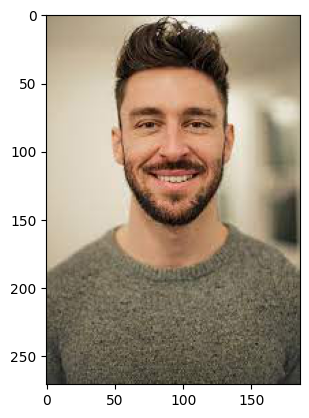

30-50 yrs old
Male


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''
loadImage is used to upload an image from Google Drive and normalize it
'''
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/images.jpeg"
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)
plt.imshow(img)
plt.show()
maxAge=-1
count=0

for i in age_pred[0]:
  if i>maxAge:
    maxAge = i
    temp = count
  count+=1

if temp==0:
  print('0-16 yrs old')
if temp==1:
  print('20-35 yrs old')
if temp==2:
  print('30-50 yrs old')
if temp==3:
  print('60-80 yrs old')
if temp==4:
  print('90-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

1/1 [==============================] - 0s 23ms/step


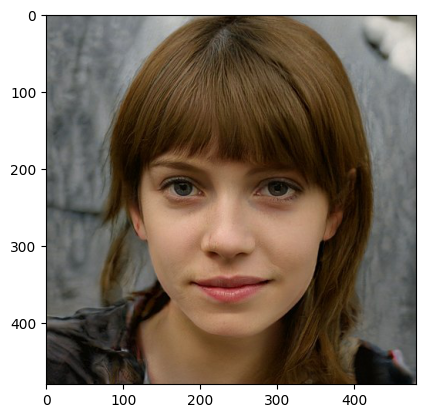

0-16 yrs old
Female


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/woman.jpg"
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)
plt.imshow(img)
plt.show()

maxAge=-1
count=0

for i in age_pred[0]:
  if i>maxAge:
    maxAge = i
    temp = count
  count+=1

if temp==0:
  print('0-16 yrs old')
if temp==1:
  print('20-35 yrs old')
if temp==2:
  print('30-50 yrs old')
if temp==3:
  print('60-80 yrs old')
if temp==4:
  print('30-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

1/1 [==============================] - 0s 25ms/step


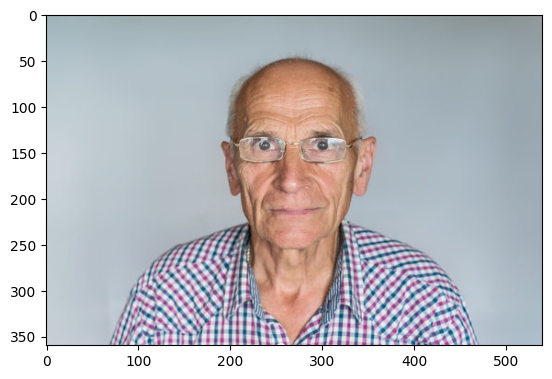

60-80 yrs old
Male


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/old.jpg"
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)
plt.imshow(img)
plt.show()
maxAge=-1
count=0

for i in age_pred[0]:
  if i>maxAge:
    maxAge = i
    temp = count
  count+=1

if temp==0:
  print('0-16 yrs old')
if temp==1:
  print('20-35 yrs old')
if temp==2:
  print('30-50 yrs old')
if temp==3:
  print('60-80 yrs old')
if temp==4:
  print('30-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')

In [ ]:
# Downloading pretrained data and unzipping it
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/modelNweight.zip
100% 86.2M/86.2M [00:01<00:00, 53.5MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [ ]:
# Get the frame of the person's face
def getFaceBox(net, frame, conf_threshold=0.7):  # Entries: a neural network object, a video frame, and a confidence threshold
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)
    ''' 1.0 Scale Factor (Intensity of pixels)
        300 x 300 Size of image
        [104, 117, 123] substraction to brightness and intesity RGB
        TRUE swap the R and B channels in the input image
        FALSE  the input image should be cropped after resizing or not
    '''
    # Pass the pretreated image to the pretrained model
    net.setInput(blob)
    detections = net.forward() # Forward pass
    bboxes = []
    # extract the bounding box coordinates of detected objects in the input image
    for i in range(detections.shape[2]): # number of detected objects in the input image
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes # Outputs: Coordinates + old frame edited

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import math
from google.colab.patches import cv2_imshow
faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"
faceNet = cv2.dnn.readNet(faceModel, faceProto)
padding = 20 # To include the whole face
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

error: ignored

In [ ]:
# Using the models
import builtins # To avoid conflict
def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        y1 = builtins.max(0, bbox[1] - padding)
        y2 = builtins.min(bbox[3] + padding, frame.shape[0] - 1)
        x1 = builtins.max(0, bbox[0] - padding)
        x2 = builtins.min(bbox[2] + padding, frame.shape[1] - 1)
        face = frame[y1:y2, x1:x2]
        # face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):,min(bbox[2]+padding, frame.shape[1]-1)]
        # resize the face to the expected input size of the model
        face = cv2.resize(face, (198, 198))
        # preprocess the image
        face = face.astype('float32') / 255.0
        # add a batch dimension
        face = np.expand_dims(face, axis=0)
        # make predictions
        age_pred, gender_pred = new_model.predict(face)
        maxAge=-1
        count=0
        for i in age_pred[0]:
          if i>maxAge:
            maxAge = i
            temp = count
          count+=1

        if temp==0:
          age ='0-16 yrs old'
        if temp==1:
          age = '20-35 yrs old'
        if temp==2:
          age = '30-50 yrs old'
        if temp==3:
          age = '60-80 yrs old'
        if temp==4:
          age = '90-124 yrs old'
        if gender_pred[0][0]>gender_pred[0][1]:
          gender = 'Male'
        else:
          gender = 'Female'
        label = "{},{}".format(gender,age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    return frameFace # annotated frame frameFace.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
# def bbox_to_bytes(bbox_array):
#   """
#   Params:
#           bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
#   Returns:
#         bytes: Base64 image byte string
#   """
#   # convert array into PIL image
#   bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
#   iobuf = io.BytesIO()
#   # format bbox into png for return
#   bbox_PIL.save(iobuf, format='png')
#   # format return string
#   bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

#   return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

count = 0
while True: # HERE I WANT UN CAPTEUR DE DISTANCE OR A SIGN THAT SOMEONE HAS COME TO BUY SOMETHING
    js_reply = video_frame(label_html, bbox)

    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    output = age_gender_detector(img)
    cv2_imshow(output)


1/1 [==============================] - 0s 22ms/step


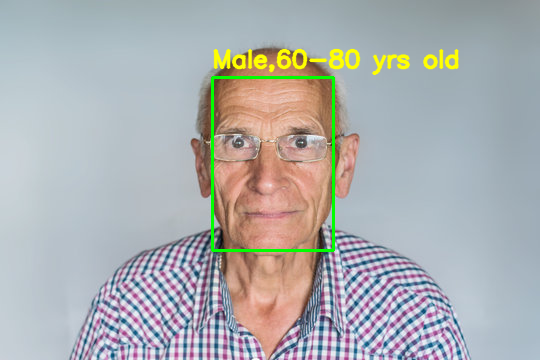

In [ ]:
# Load the image from Google Drive
img_path = "/content/drive/My Drive/old.jpg"
img = cv2.imread(img_path)

# Call the age_gender_detector function on the image
output = age_gender_detector(img)

# Display the output
cv2_imshow(output)

1/1 [==============================] - 0s 22ms/step


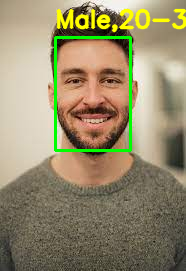

In [ ]:
# Load the image from Google Drive
img_path = "/content/drive/My Drive/images.jpeg"
img = cv2.imread(img_path)

# Call the age_gender_detector function on the image
output = age_gender_detector(img)

# Display the output
cv2_imshow(output)

1/1 [==============================] - 0s 34ms/step


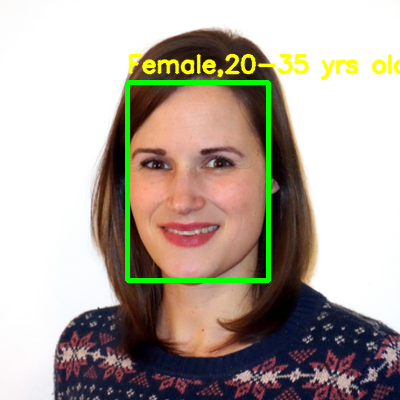

In [ ]:
# Load the image from Google Drive
img_path = "/content/drive/My Drive/pic.png"
img = cv2.imread(img_path)

# Call the age_gender_detector function on the image
output = age_gender_detector(img)

# Display the output
cv2_imshow(output)

In [ ]:
# Load the image from Google Drive
img_path = "/content/drive/My Drive/babb.jpg"
img = cv2.imread(img_path)

# Call the age_gender_detector function on the image
output = age_gender_detector(img)

# Display the output
cv2_imshow(output)